In [28]:
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

file_path = r"C:\Users\nstep\TSU\SeniorProject\df_selected1.csv"
nashvilleDF = pd.read_csv(file_path)

In [29]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=str(coef))
    return d

def str_to_dot(string):
    '''
    Converts input string from graphviz library to valid DOT graph format.
    '''
    graph = string.strip().replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1] # Removing unnecessary characters from string
    return graph

In [30]:
print(nashvilleDF.shape)

nashvilleDF.head()

(8580, 31)


,grill,private entrance,free parking,review_scores_location,resort access,review_scores_rating,bedrooms,beds,pool,host_acceptance_rate,...,prop_Entire condo,prop_Entire guest suite,prop_Entire guesthouse,prop_Entire home,prop_Entire rental unit,prop_Entire townhouse,prop_Hotel,prop_Private room,room_Entire home/apt,room_Private room
0,0,0,0,4.92,0,4.95,1,1,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0,0,1,4.94,0,4.94,1,1,0,93,...,0,0,0,0,0,0,0,1,0,1
2,0,0,0,4.96,0,4.91,2,2,0,100,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,4.74,0,4.77,1,2,0,91,...,0,0,0,0,0,0,0,1,0,1
4,0,0,1,4.47,0,4.71,1,3,0,91,...,0,0,0,0,0,0,0,1,0,1


In [31]:
nashvilleDF = nashvilleDF.drop(columns=['id','prop_Entire condo', 'prop_Entire guest suite',
                                        'prop_Entire guesthouse', 'prop_Entire rental unit',
                                        'prop_Entire townhouse', 'prop_Hotel', 'prop_Private room'])


Method : LiNGAM


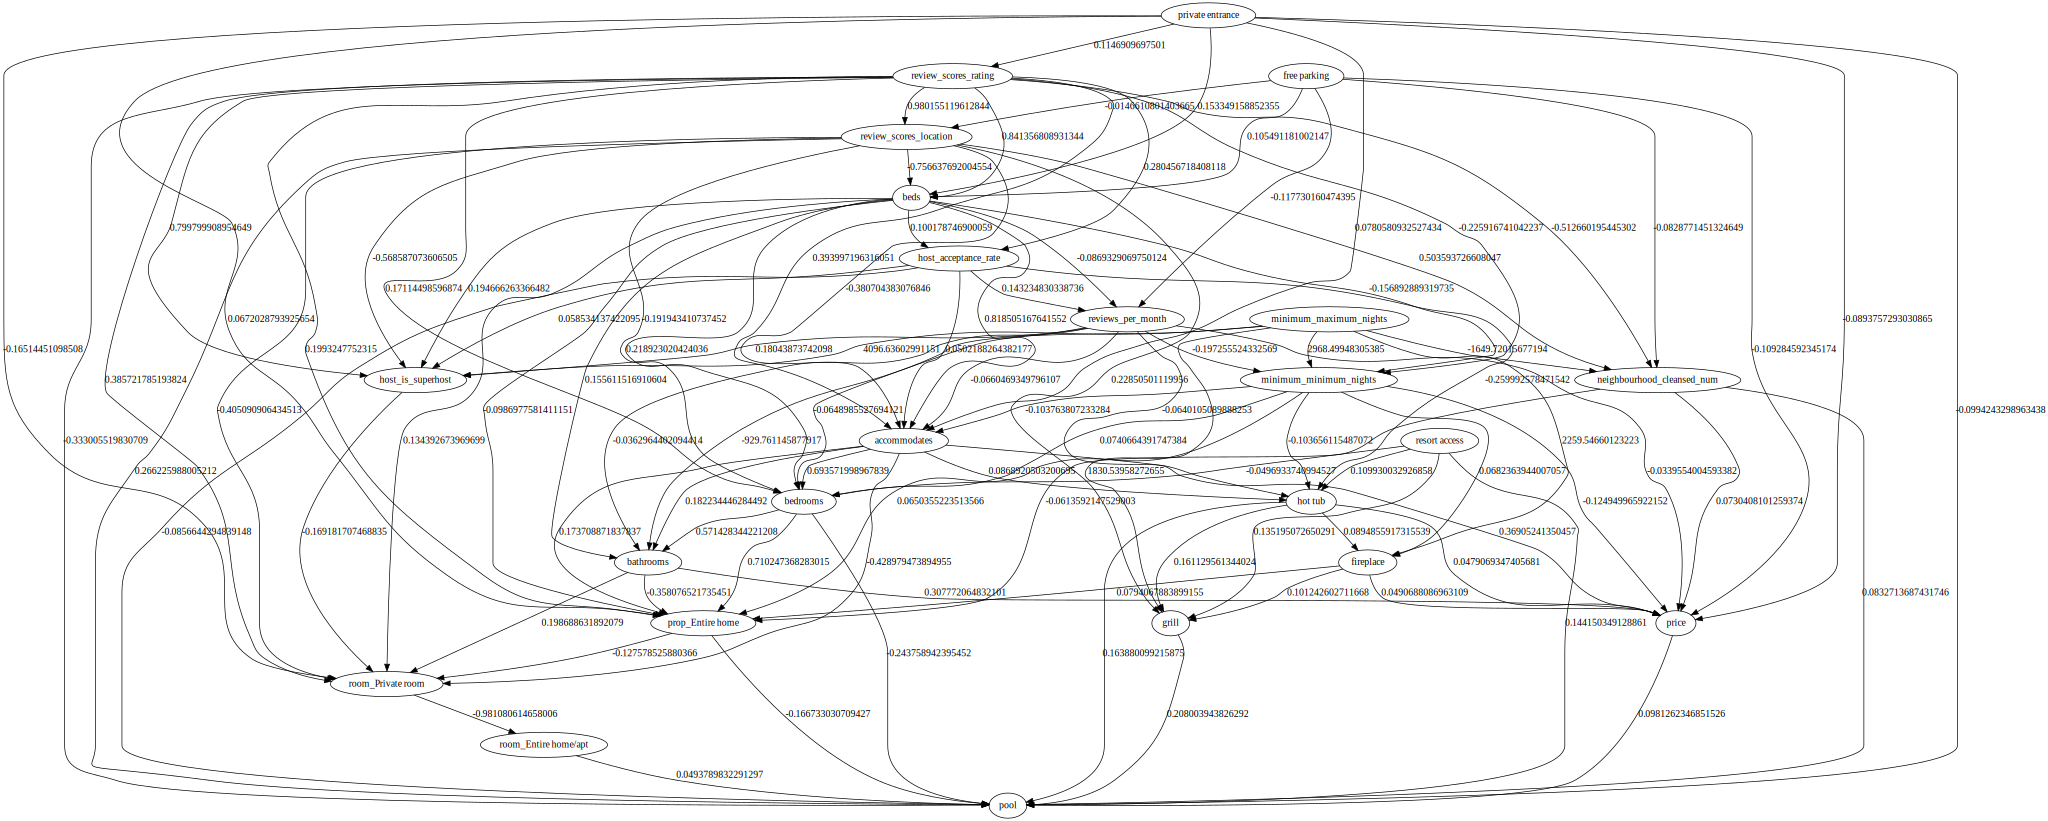

Method : PC


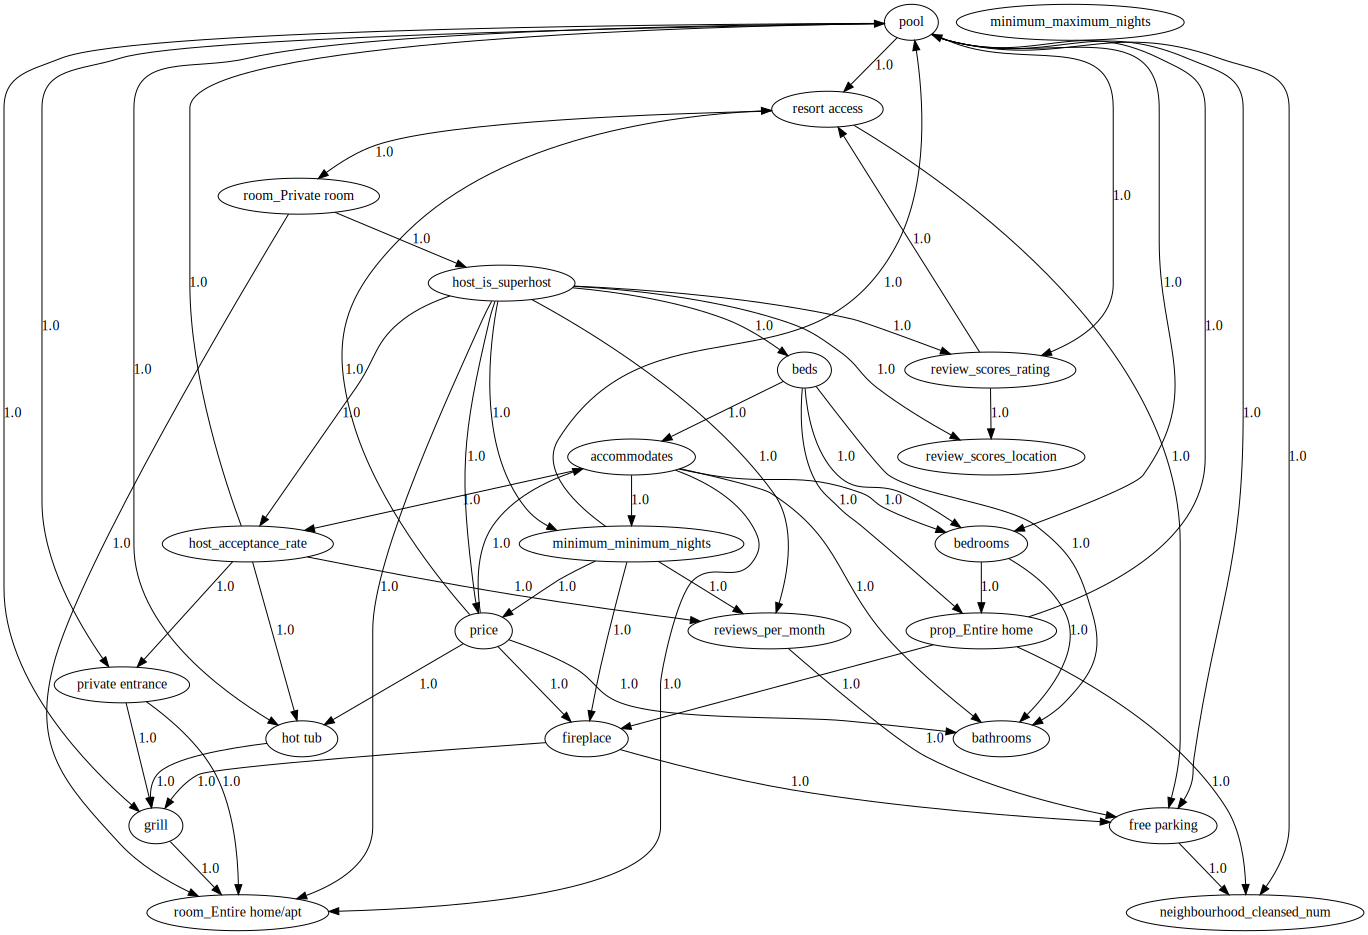

Method : GES


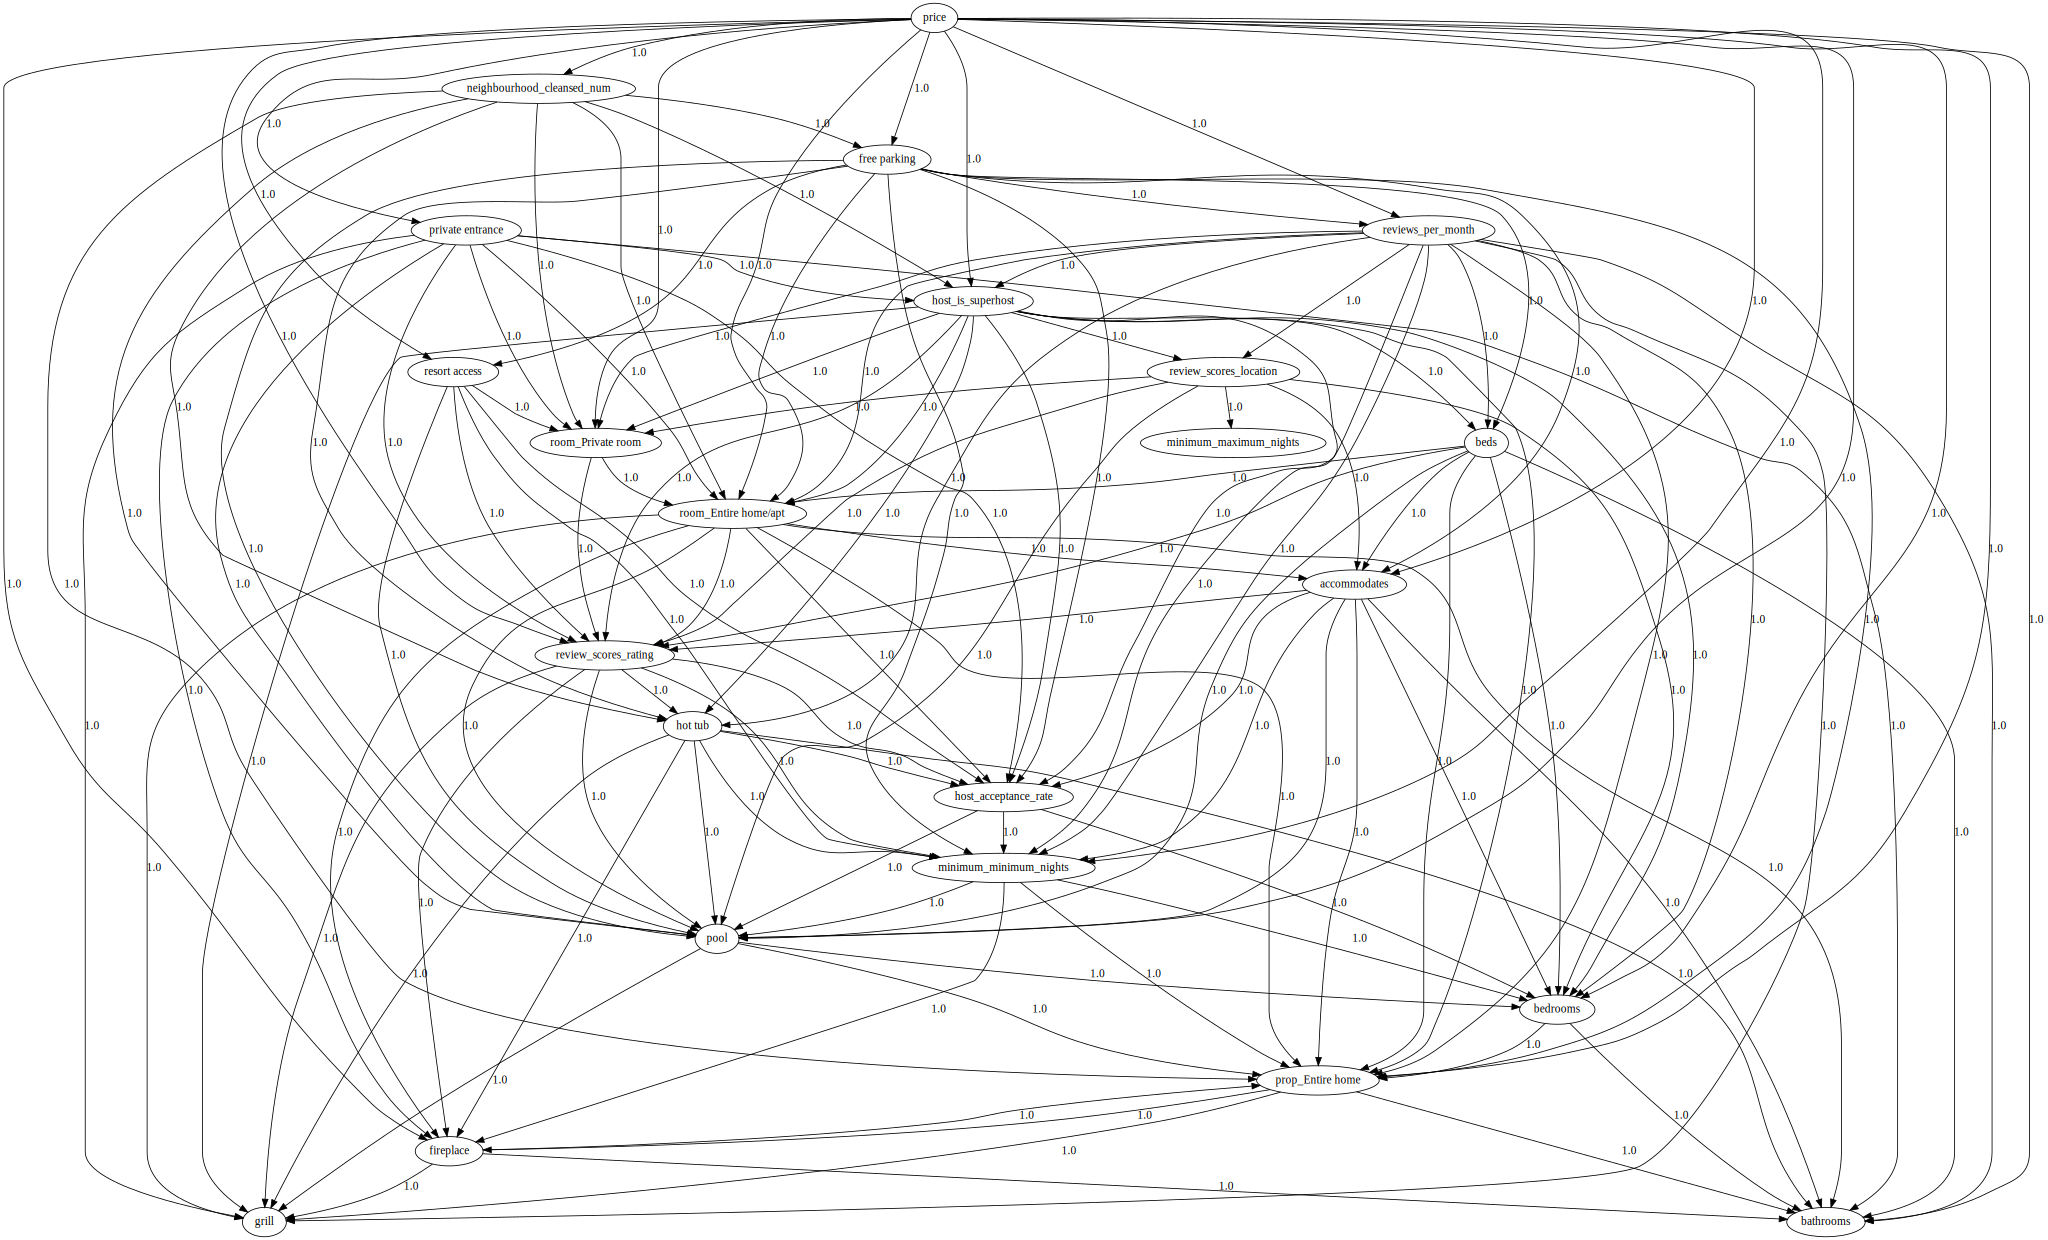

In [32]:
from cdt.causality.graph import LiNGAM, PC, GES
import graphviz
from sklearn.preprocessing import StandardScaler


import os
os.environ['R_HOME'] = 'C:\\Program Files\\R\\R-4.3.1'
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

scaler = StandardScaler()
nashvilleDF_scaled = pd.DataFrame(scaler.fit_transform(nashvilleDF), columns=nashvilleDF.columns)
from sklearn.decomposition import PCA

pca = PCA(n_components=min(nashvilleDF_scaled.shape) - 1)  # -1 to ensure the matrix is non-singular
nashvilleDF_pca = pca.fit_transform(nashvilleDF_scaled)




graphs = {}
labels = [f'{col}' for i, col in enumerate(nashvilleDF.columns)]
functions = {
    'LiNGAM' : LiNGAM,
    'PC': PC,
    'GES': GES,
}


for method, lib in functions.items():
    obj = lib()
    output = obj.predict(nashvilleDF_scaled)
    adj_matrix = nx.to_numpy_array(output)
    adj_matrix = np.asarray(adj_matrix)
    graph_dot = make_graph(adj_matrix, labels)
    graphs[method] = graph_dot

# Visualize graphs
for method, graph in graphs.items():
    print("Method : %s" % (method))
    display(graph)


In [33]:
for method, graph in graphs.items():
        if method != "LiNGAM":
            continue
        print('\n*****************************************************************************\n')
        print("Causal Discovery Method : %s"%(method))

        # Obtain valid dot format
        graph_dot = str_to_dot(graph.source)

        # Define Causal Model
        model=CausalModel(
                data = nashvilleDF,
                treatment='accommodates',
                outcome='price',
                graph=graph_dot)

        # Identification
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
        print(identified_estimand)

        # Estimation
        estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                        control_value=0,
                                        treatment_value=1,
                                        confidence_intervals=True,
                                        test_significance=True)
        print("Causal Estimate is " + str(estimate.value))


*****************************************************************************

Causal Discovery Method : LiNGAM
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                      
───────────────(E[price|beds,private entrance,reviews_per_month,minimum_minimu
d[accommodates]                                                               

                                                                           
m_nights,host_acceptance_rate,review_scores_rating,review_scores_location])
                                                                           
Estimand assumption 1, Unconfoundedness: If U→{accommodates} and U→price then P(price|accommodates,beds,private entrance,reviews_per_month,minimum_minimum_nights,host_acceptance_rate,review_scores_rating,review_scores_location,U) = P(price|accommodates,beds,private entrance,reviews_per_month,minimum_minimum_nights,host_acce

In [34]:

# Create the updated causal graph
causal_graph_updated = f"""
digraph {{
  beds -> bedrooms;
  bedrooms -> accommodates;
  bedrooms -> price;
  accommodates -> price;
  number_of_reviews -> price;
  review_scores_rating -> price;
  neighbourhood_cleansed_num -> bedrooms;
  neighbourhood_cleansed_num -> accommodates;
  neighbourhood_cleansed_num -> price;
  pool -> price;
  host_is_superhost -> price;
  accommodates -> bathrooms;
  bathrooms -> price;
  "hot tub" -> price;
  host_response_time -> price;
}}
"""





# Define Causal Model
model=CausalModel(
        data = nashvilleDF,
        treatment='accommodates',
        outcome='price',
        graph=causal_graph_updated)

# Identification
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

# Estimation
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 control_value=0,
                                 treatment_value=1,
                                 confidence_intervals=True,
                                 test_significance=True)
print("Causal Estimate is " + str(estimate.value))

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                     
───────────────(E[price|bedrooms,neighbourhood_cleansed_num])
d[accommodates]                                              
Estimand assumption 1, Unconfoundedness: If U→{accommodates} and U→price then P(price|accommodates,bedrooms,neighbourhood_cleansed_num,U) = P(price|accommodates,bedrooms,neighbourhood_cleansed_num)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': True, 'target_units': 'ate', 'effect_modifiers': ['pool', 'host_is_superhost', 'number_of_reviews', 'host_response_time', 'review_scores_rating', 'hot tub']}
{'treatment_value': 1, 'control_value': 0, 'test_significance': False, 'evaluate_